In [1]:
import numpy as np
import pandas as pd

import os
import math

import time

import albumentations as albu
from albumentations.pytorch import ToTensor
import PIL
import cv2 as cv

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam,lr_scheduler

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding, get_model_params

from tqdm import tqdm_notebook, tqdm

In [2]:
HOST = "app.verta.ai"

PROJECT_NAME = "BengaliAI"
EXPERIMENT_NAME = "EffNet"

In [3]:
os.environ['VERTA_EMAIL'] = 'astakhova.aleksandra@gmail.com'
os.environ['VERTA_DEV_KEY'] = 'd7ee32b5-bbd0-4c4c-a2ec-a070848021be'

In [29]:
from verta import Client
from verta.utils import ModelAPI

client = Client(HOST)
proj = client.set_project(PROJECT_NAME)
expt = client.set_experiment(EXPERIMENT_NAME)
run = client.set_experiment_run()

run.log_tag('EffNet')

set email from environment
set developer key from environment
connection successfully established
set existing Project: BengaliAI
set existing Experiment: EffNet
created new ExperimentRun: Run 1745215793920591274464


## Load the Dataset

In [5]:
# setup the input data folder
DATA_PATH = './data/'

In [6]:
# load the dataframes with labels
train_labels = pd.read_csv(DATA_PATH + 'train.csv')
test_labels = pd.read_csv(DATA_PATH + 'test.csv')
class_map = pd.read_csv(DATA_PATH + 'class_map.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [7]:
class_map.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [8]:
def load_images():
    '''
    Helper function to load all train and test images
    '''
    train_list = []
    for i in range(0,4):
        train_list.append(pd.read_parquet(DATA_PATH + 'train_image_data_{}.parquet'.format(i)))
    train = pd.concat(train_list, ignore_index=True)
    
    test_list = []
    for i in range(0,4):
        test_list.append(pd.read_parquet(DATA_PATH + 'test_image_data_{}.parquet'.format(i)))
    test = pd.concat(test_list, ignore_index=True)
    
    return train, test

In [9]:
train, test = load_images()

## Image Preprocessing and Augmentations

In [10]:
# setup image hight and width
HEIGHT = 137
WIDTH = 236
SIZE = 128

# Source:
# https://www.kaggle.com/iafoss/image-preprocessing-128x128

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove low intensity pixels as noise
    #img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv.resize(img,(size,size))

def threshold_image(img):
    '''
    Helper function for thresholding the images
    '''
    gray = PIL.Image.fromarray(np.uint8(img), 'L')
    ret,th = cv.threshold(np.array(gray),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return th

def train_transforms(p=.5):
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        # compose the random cropping and random rotation
        albu.RandomSizedCrop(min_max_height=(int(SIZE // 1.1), SIZE), height = SIZE, width = SIZE, p=p),
        albu.Rotate(limit=5, p=p)
    ], p=1.0)

def valid_transforms():
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        # compose the random cropping and random rotation
        albu.Resize(height = SIZE, width = SIZE)
    ], p=1.0)

## Define the Dataset

Create the custom dataset:

In [11]:
def get_image(idx, df, labels):
    '''
    Helper function to get the image and label from the training set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    # get the labels
    row = labels[labels.image_id == image_id]
    labels = row['grapheme_root'].values[0], \
    row['vowel_diacritic'].values[0], \
    row['consonant_diacritic'].values[0]
    
    return img, labels

def get_validation(idx, df):
    '''
    Helper function to get the validation image and image_id from the test set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    return img, image_id

class BengaliDataset(Dataset):
    '''
    Create custom Bengali dataset
    '''
    def __init__(self, df_images, transforms, df_labels = None, validation = False):
        self.df_images = df_images
        self.df_labels = df_labels
        self.transforms = transforms
        self.validation = validation

    def __len__(self):
        return len(self.df_images)

    def __getitem__(self, idx):
        if not self.validation:
            img, label = get_image(idx, self.df_images, self.df_labels)
            img = 255.0 - img
            img = (img*(255.0/img.max())).astype(np.uint8)
            img = crop_resize(img, size=SIZE, pad=16)
            img = threshold_image(img)
            img = 255 - img
            aug = self.transforms(image = img)
            return TF.to_tensor(aug['image']), label
        else:
            img, image_id = get_validation(idx, self.df_images)
            img = 255.0 - img
            img = (img*(255.0/img.max())).astype(np.uint8)
            img = crop_resize(img, size=SIZE, pad=16)
            img = threshold_image(img)
            img = 255 - img
            if self.transforms != None:
                aug = self.transforms(image = img)
                return TF.to_tensor(aug['image']), image_id
            else:
                return img, image_id

Try to get some images and labels from the dataset:

In [12]:
# initialize train dataset
train_dataset = BengaliDataset(train, train_transforms(), train_labels)
sample_trainloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)

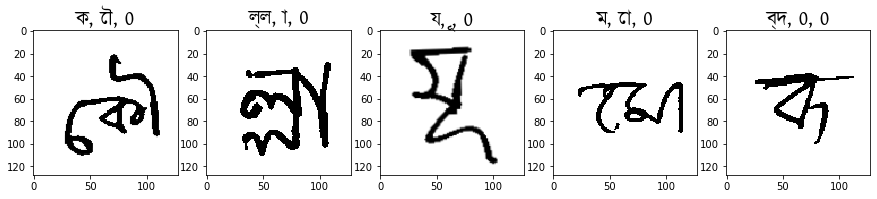

In [13]:
# plot sample train data
for img, labels in sample_trainloader:
    
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(TF.to_pil_image(img[i].reshape(SIZE, SIZE)), cmap='gray')
        
        prop = FontProperties()
        prop.set_file('./kalpurush.ttf')
        grapheme_root = class_map[(class_map.component_type == 'grapheme_root') \
                                  & (class_map.label == int(labels[0][i]))].component.values[0]
        
        vowel_diacritic = class_map[(class_map.component_type == 'vowel_diacritic') \
                                  & (class_map.label == int(labels[1][i]))].component.values[0]
        
        consonant_diacritic = class_map[(class_map.component_type == 'consonant_diacritic') \
                                  & (class_map.label == int(labels[2][i]))].component.values[0]
        
        axs[i].set_title('{}, {}, {}'.format(grapheme_root, vowel_diacritic, consonant_diacritic), 
                         fontproperties=prop, fontsize=20)
    break;

## Define the Model

Load the EfficientNet model:

In [14]:
'''
EffNet: AN EFFICIENT STRUCTURE FOR CONVOLUTIONAL NEURAL NETWORKS
Implementation in Pytorch of Effnet.
https://arxiv.org/abs/1801.06434
'''
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x
     
class EffNet(nn.Module):

    def __init__(self, nb_classes=1000, include_top=True, weights=None):
        super(EffNet, self).__init__()
        
        self.block1 = self.make_layers(32, 64)
        self.block2 = self.make_layers(64, 128)
        self.block3 = self.make_layers(128, 256)
        self.flatten = Flatten()
        self.linear = nn.Linear(65536, nb_classes)
        self.include_top = include_top
        self.weights = weights

    def make_layers(self, ch_in, ch_out):
        layers = [
            nn.Conv2d(1, ch_in, kernel_size=(1,1), stride=(1,1), bias=False, padding=0, dilation=(1,1)) if ch_in ==32 else nn.Conv2d(ch_in, ch_in, kernel_size=(1,1),stride=(1,1), bias=False, padding=0, dilation=(1,1)) ,
            self.make_post(ch_in),
            # DepthWiseConvolution2D
            nn.Conv2d(ch_in, 1 * ch_in, groups=ch_in, kernel_size=(1, 3),stride=(1,1), padding=(0,1), bias=False, dilation=(1,1)),
            self.make_post(ch_in),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),
            # DepthWiseConvolution2D
            nn.Conv2d(ch_in, 1 * ch_in, groups=ch_in, kernel_size=(3, 1), stride=(1,1), padding=(1,0), bias=False, dilation=(1,1)),
            self.make_post(ch_in),
            nn.Conv2d(ch_in, ch_out, kernel_size=(1, 2), stride=(1, 2), bias=False, padding=(0,0), dilation=(1,1)),
            self.make_post(ch_out),
        ]
        return nn.Sequential(*layers)

    def make_post(self, ch_in):
        layers = [
            nn.LeakyReLU(0.3),
            nn.BatchNorm2d(ch_in, momentum=0.99)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        if self.include_top:
            x = self.flatten(x)
            x = self.linear(x)
        return x

In [15]:
backbone_model = EffNet(nb_classes=1000)

In [16]:
class BengaliModel(nn.Module):
    def __init__(self, backbone_model):
        super(BengaliModel, self).__init__()
        #self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)
        self.backbone_model = backbone_model
        self.fc1 = nn.Linear(in_features=1000, out_features=168) # grapheme_root
        self.fc2 = nn.Linear(in_features=1000, out_features=11) # vowel_diacritic
        self.fc3 = nn.Linear(in_features=1000, out_features=7) # consonant_diacritic
        
    def forward(self, x):
        # pass through the backbone model
        #y = self.conv(x)
        y = self.backbone_model(x)
        
        # multi-output
        grapheme_root = self.fc1(y)
        vowel_diacritic = self.fc2(y)
        consonant_diacritic = self.fc3(y)
        
        return grapheme_root, vowel_diacritic, consonant_diacritic

In [17]:
model = BengaliModel(backbone_model)

## Setup the Training

The hyperparameters:

In [18]:
test_split = 0.2
batch_size = 64
epochs = 10
learning_rate = 0.001
num_workers = 0

In [37]:
run.log_hyperparameter("test_split", test_split)
run.log_hyperparameter("batch_size", batch_size)
run.log_hyperparameter("epochs", epochs)
run.log_hyperparameter("learning_rate", learning_rate)
run.log_hyperparameter("image_size", SIZE)

Setup the samplers:

In [20]:
dataset_size = len(train_dataset)

indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = DataLoader(train_dataset, batch_size=32, sampler=test_sampler, num_workers=num_workers)

Setup the loss function and the optimizer:

In [21]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)

In [38]:
run.log_hyperparameter("optimizer", "Adam")
run.log_hyperparameter("loss", "CrossEntropyLoss")

Setup the device:

In [23]:
# setup training device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Initialize the dataframe to store training statistics:

In [24]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy'
                                      ,'Test loss', 'Test accuracy'])

## Train the Model

In [25]:
def get_accuracy(ps, labels):
    ps = torch.exp(ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
    return accuracy

In [26]:
#train the model
model = model.to(device)

In [27]:
#state = torch.load('mobilenet_v2_10.pth', map_location=lambda storage, loc: storage)
#model.load_state_dict(state["state_dict"])

In [31]:
steps = 0
running_loss = 0
model.train()
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in tqdm_notebook(trainloader):
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), [label.to(device) for label in labels]
        
        optimizer.zero_grad()
        
        grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
        
        loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + \
        criterion(consonant_diacritic, labels[2])
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        train_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2])) / 3.0

        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), [label.to(device) for label in labels]
            
            grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
            batch_loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + criterion(consonant_diacritic, labels[2])
        
            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            test_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2])) / 3.0
            
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. ")

    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader),
                                      'Train accuracy': train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader),
                                      'Test accuracy': test_accuracy/len(testloader)}, ignore_index=True)
    
    run.log_observation("time_per_epoch", time_elapsed)
    run.log_observation("time_per_step", time_elapsed/len(trainloader))
    run.log_observation("train_loss", running_loss/len(trainloader))
    run.log_observation("test_loss", test_loss/len(testloader))
    
    filename = 'effnet_'+ str(epoch+1) + '.pth'
    checkpoint = {'state_dict': model.state_dict()}
    torch.save(checkpoint, filename)

    running_loss = 0
    steps = 0
    model.train()

d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Epoch 1/10.. Time per epoch: 5515.1676.. Average time per step: 2.1964.. Train loss: 1.9329.. Train accuracy: 0.8088.. Test loss: 1.9166.. Test accuracy: 0.8136.. 



Epoch 2/10.. Time per epoch: 5551.3493.. Average time per step: 2.2108.. Train loss: 1.6844.. Train accuracy: 0.8325.. Test loss: 1.8068.. Test accuracy: 0.8243.. 



Epoch 3/10.. Time per epoch: 5514.9583.. Average time per step: 2.1963.. Train loss: 1.5013.. Train accuracy: 0.8501.. Test loss: 1.6371.. Test accuracy: 0.8404.. 



Epoch 4/10.. Time per epoch: 5954.4050.. Average time per step: 2.3713.. Train loss: 1.3531.. Train accuracy: 0.8632.. Test loss: 1.6230.. Test accuracy: 0.8436.. 



Epoch 5/10.. Time per epoch: 5808.3380.. Average time per step: 2.3132.. Train loss: 1.2420.. Train accuracy: 0.8739.. Test loss: 1.6080.. Test accuracy: 0.8497.. 



Epoch 6/10.. Time per epoch: 5588.3381.. Average time per step: 2.2255.. Train loss: 1.1499.. Train accuracy: 0.8828.. Test loss: 1.6232.. Test accuracy: 0.8480.. 



Epoch 7/10.. Time per epoch: 5593.2511.. Average time per step: 2.2275.. Train loss: 1.0731.. Train accuracy: 0.8897.. Test loss: 1.6237.. Test accuracy: 0.8527.. 



Epoch 8/10.. Time per epoch: 5606.7689.. Average time per step: 2.2329.. Train loss: 1.0126.. Train accuracy: 0.8961.. Test loss: 1.7088.. Test accuracy: 0.8506.. 



Epoch 9/10.. Time per epoch: 5655.8962.. Average time per step: 2.2524.. Train loss: 0.9644.. Train accuracy: 0.9009.. Test loss: 1.7080.. Test accuracy: 0.8528.. 



Epoch 10/10.. Time per epoch: 5625.1172.. Average time per step: 2.2402.. Train loss: 0.9179.. Train accuracy: 0.9051.. Test loss: 1.7690.. Test accuracy: 0.8493.. 


Save weights and training statistics:

In [32]:
filename = 'effnet_'+ str(epochs) + '.pth'

checkpoint = {'state_dict': model.state_dict()}

torch.save(checkpoint, filename)

In [33]:
run.log_dataset('model', checkpoint)

upload complete (model.pkl)


In [34]:
train_stats

,Epoch,Time per epoch,Avg time per step,Train loss,Train accuracy,Test loss,Test accuracy
0,0.0,5550.563564,2.210499,7.743629,0.544896,3.186750,0.701234
1,0.0,5513.690551,2.195815,2.448289,0.762329,2.130714,0.791517
2,0.0,5515.167624,2.196403,1.932893,0.808831,1.916581,0.813636
3,1.0,5551.349283,2.210812,1.684420,0.832485,1.806811,0.824285
4,2.0,5514.958261,2.196319,1.501324,0.850076,1.637139,0.840399
5,3.0,5954.405040,2.371328,1.353085,0.863202,1.622958,0.843617
6,4.0,5808.337966,2.313157,1.241957,0.873915,1.608040,0.849746
7,5.0,5588.338115,2.225543,1.149901,0.882772,1.623211,0.847980
8,6.0,5593.251053,2.227499,1.073132,0.889652,1.623732,0.852715
9,7.0,5606.768870,2.232883,1.012609,0.896122,1.708843,0.850617


In [35]:
train_stats.to_csv('train_stats_{}.csv'.format(epochs))

In [36]:
run.log_dataset('train_stats', train_stats)

upload complete (train_stats.pkl)


## Plot Training Statistics

In [ ]:
plt.plot(train_stats['Train loss'], label='train')
plt.plot(train_stats['Test loss'], label='test')
plt.title('Loss over epoch')
plt.legend()

run.log_image("loss", plt)

plt.show()

In [ ]:
plt.plot(train_stats['Train accuracy'], label='train')
plt.plot(train_stats['Test accuracy'], label='test')
plt.title('Accuracy over epoch')
plt.legend()
run.log_image("accuracy", plt)
plt.show()

## Look at Sample Predictions

In [ ]:
# plot sample train data
model.eval()
for img, labels in testloader:
    img, labels = img.to(device), [label.to(device) for label in labels]
    grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(img)
    
    img = img.cpu()
    grapheme_root = grapheme_root.cpu()
    vowel_diacritic = vowel_diacritic.cpu()
    consonant_diacritic = consonant_diacritic.cpu()
    
    # visualize the inputs
    fig, axs = plt.subplots(4, 1, figsize=(10,15))
    for i in range(0, img.shape[0]):
        axs[0].imshow(TF.to_pil_image(img[i].reshape(SIZE, SIZE)), cmap='gray')
        
        prop = FontProperties()
        prop.set_file('./kalpurush.ttf')
        grapheme_root_str = class_map[(class_map.component_type == 'grapheme_root') \
                                  & (class_map.label == int(labels[0][i]))].component.values[0]
        
        vowel_diacritic_str = class_map[(class_map.component_type == 'vowel_diacritic') \
                                  & (class_map.label == int(labels[1][i]))].component.values[0]
        
        consonant_diacritic_str = class_map[(class_map.component_type == 'consonant_diacritic') \
                                  & (class_map.label == int(labels[2][i]))].component.values[0]
        
        axs[0].set_title('{}, {}, {}'.format(grapheme_root_str, vowel_diacritic_str, consonant_diacritic_str), 
                         fontproperties=prop, fontsize=20)
        
        # analyze grapheme root prediction
        ps_root = F.softmax(grapheme_root[i])
        top10_p, top10_class = ps_root.topk(10, dim=0)
        
        top10_p = top10_p.detach().numpy()
        top10_class = top10_class.detach().numpy()
        
        axs[1].bar(range(len(top10_p)), top10_p)
        axs[1].set_xticks(range(len(top10_p)))
        axs[1].set_xticklabels(top10_class)
        axs[1].set_title('grapheme_root: {}'.format(labels[0][i]))
        
        # analyze vowel prediction
        ps_vowel = F.softmax(vowel_diacritic[i])
        top11_p, top11_class = ps_vowel.topk(11, dim=0)
        
        top11_p = top11_p.detach().numpy()
        top11_class = top11_class.detach().numpy()
        
        axs[2].bar(range(len(top11_p)), top11_p)
        axs[2].set_xticks(range(len(top11_p)))
        axs[2].set_xticklabels(top11_class)
        axs[2].set_title('vowel_diacritic: {}'.format(labels[1][i]))
        
        # analyze consonant prediction
        ps_cons = F.softmax(consonant_diacritic[i])
        top7_p, top7_class = ps_cons.topk(7, dim=0)
        
        top7_p = top7_p.detach().numpy()
        top7_class = top7_class.detach().numpy()
        
        axs[3].bar(range(len(top7_p)), top7_p)
        axs[3].set_xticks(range(len(top7_p)))
        axs[3].set_xticklabels(top7_class)
        axs[3].set_title('consonant_diacritic: {}'.format(labels[2][i]))
        
        plt.show()
        break;
        
    break;

## Create Submission

Initialize test dataset and visualize sample test images:

In [ ]:
# initialize train dataset
test_dataset = BengaliDataset(test, valid_transforms(), test_labels, validation = True)

In [ ]:
sample_validloader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=0)

In [ ]:
# plot sample train data
for img, image_ids in sample_validloader:
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(TF.to_pil_image(img[i].reshape(SIZE, SIZE)), cmap='gray')
        axs[i].set_title(image_ids[i])
    break;

Make predictions for the test set:

In [ ]:
validloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
def get_predicted_label(ps):
    ps = F.softmax(ps)[0]
    top_p, top_class = ps.topk(1, dim=0)
        
    top_p = top_p.detach().numpy()
    top_class = top_class.detach().numpy()
    
    return top_class[0]

In [ ]:
submission = pd.DataFrame(columns=['row_id', 'target'])

for imgs, image_ids in validloader:
    img = imgs[0]
    image_id = image_ids[0]
    
    imgs = imgs.to(device)
    
    grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(imgs)
    
    imgs = imgs.cpu()
    grapheme_root = grapheme_root.cpu()
    vowel_diacritic = vowel_diacritic.cpu()
    consonant_diacritic = consonant_diacritic.cpu()
    
    grapheme_root_label = get_predicted_label(grapheme_root)
    vowel_diacritic_label = get_predicted_label(vowel_diacritic)
    consonant_diacritic_label = get_predicted_label(consonant_diacritic)
    
    submission = submission.append({'row_id':str(image_id)+'_grapheme_root', 'target':grapheme_root_label}, 
                                   ignore_index=True)
    submission = submission.append({'row_id':str(image_id)+'_vowel_diacritic', 'target':vowel_diacritic_label}, 
                                   ignore_index=True)
    submission = submission.append({'row_id':str(image_id)+'_consonant_diacritic', 'target':consonant_diacritic_label}, 
                                   ignore_index=True)

In [ ]:
submission

In [ ]:
submission.to_csv('submission.csv')